In [3]:
from ultralytics import YOLO
import torch
import torchvision
from torch import nn
# import torchsummary as summary
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os

In [7]:
pred = torch.randn(32, 6)
tar = torch.randint(5, (32,))
torch.nn.functional.cross_entropy(input= pred, target= tar)
tar.shape

torch.Size([32])

In [35]:
input = torch.randn(1, 3, 5, requires_grad=True)
print(input)
target = torch.randint(low= 0, high= 5, size= (3,1))
print(target)
loss = torch.nn.functional.cross_entropy(input, target)

tensor([[[-0.2441, -0.2505,  1.2142, -0.5135,  2.0816],
         [ 0.1921, -1.8473,  1.0780, -1.3857,  1.2441],
         [-1.8547, -0.1415, -1.3565,  1.1995,  0.5695]]], requires_grad=True)
tensor([[3],
        [0],
        [4]])


ValueError: Expected input batch_size (1) to match target batch_size (3).

In [2]:
def imshow_image(img):
    num = len(img)
    print(num)
    if num == 1:
        img = img[0]
        if len(img.shape) == 3:
            img = img.unsqueeze(0)
        img = img[:,:3,:,:]
        img = img.permute(0,2,3,1).cpu()[0]
        img = img.detach().numpy()
        plt.imshow(img)
        plt.show()
    else:
        fig, ax = plt.subplots(1, num)
        for i, im in enumerate(img):
            if len(im.shape) == 3:
                im = im.unsqueeze(0)
            im = im[:,:3,:,:]
            im = im.permute(0,2,3,1).cpu()[0]
            im = im.detach().numpy()
            ax[i].imshow(im)

def plot_loss(losses):
    losses_plot = [i.cpu().detach().numpy() for i in losses]
    plt.plot(losses_plot)

def imshow_np_image(img):
    plt.imshow(img)    
    plt.show()


In [3]:
yolo = YOLO('best.pt')

In [4]:
info_label = {
    'age': ['20-30s', '40-50s', 'Baby', 'Kid', 'Senior', 'Teenager'],
    'race': ['Caucasian', 'Mongoloid', 'Negroid'],
    'masked': ['masked', 'unmasked'],
    'skintone': ['dark', 'light', 'mid-dark', 'mid-light'],
    'emotion': ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise'],
    'gender': ['Female', 'Male']
}

In [5]:
def process_out_detect(img, results):
    for r in results:
        boxes = r.boxes
        i = 0
        for box in boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 3)
            i += 1
        return i

def sample_values(lis):
    print(lis)
    lis = list(lis)
    while len(lis) < 30:
        lis.append(-1)
    return lis

def convert_to_text(key, index):
    return info_label[key][index]

def get_label(df, name, index_box):
    name = name.replace("\\", "/")
    a = df[df['file_name'] == name]
    labels = {}
    for index, i in enumerate(a.columns):
        # if index == 0:
        #     labels[i] = a[i].values[0]
        if index >= 4:
            labels[i] = convert_to_text(i, a[i].values[index_box])
    return labels

def procees_out_cls(results, index_box):
    preds = {}
    for key in results.keys():
        index = int(np.round(results[key][:,index_box].cpu().detach().numpy()))
        preds[key] = convert_to_text(key, index)
    return preds


0: 256x320 2 faces, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 256, 320)


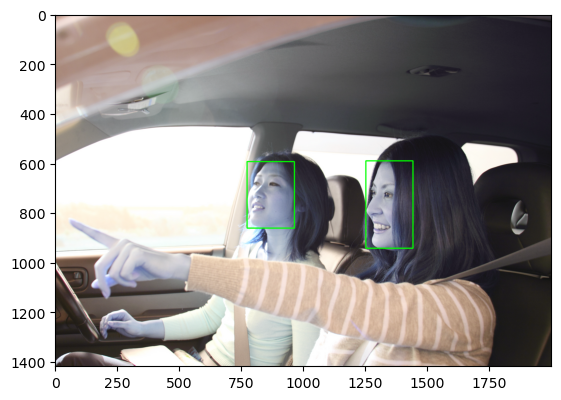

{'age': '20-30s', 'race': 'Caucasian', 'masked': 'unmasked', 'skintone': 'light', 'emotion': 'Happiness', 'gender': 'Female'}
{'age': '20-30s', 'race': 'Mongoloid', 'masked': 'unmasked', 'skintone': 'light', 'emotion': 'Happiness', 'gender': 'Female'}

{'age': '20-30s', 'race': 'Caucasian', 'masked': 'masked', 'skintone': 'dark', 'emotion': 'Anger', 'gender': 'Female'}
{'age': '20-30s', 'race': 'Mongoloid', 'masked': 'unmasked', 'skintone': 'light', 'emotion': 'Happiness', 'gender': 'Female'}



In [18]:
df = pd.read_csv("D:/Pixta/encoded_labels.csv")
path = 'D:/Pixta/mnt/md0/projects/sami-hackathon/private/data/images/'

names = os.listdir(path)
np.random.shuffle(names)
preds = []
labels = []
for name in names[:1]:
    name = '1068356.jpg'
    img_root = cv2.imread(path + name)
    # img_root = cv2.resize(img_root, (320,320))
    img = img_root.copy()

    results = yolo(img_root, stream= False)
    num_box = process_out_detect(img, results[0])
    imshow_np_image(img)

    for i in range(num_box):
        preds_cls = procees_out_cls(results[1], i)
        # preds.append(preds_cls)

        labels_dict = get_label(df, name, i)
        # labels.append(labels_dict)
        print(preds_cls)
        print(labels_dict)
        print()
# cv2.imshow('img', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()